In [48]:
import glob
from collections import namedtuple
import os
import csv
import SimpleITK as sitk
import numpy as np
import torch as t
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from torch import optim
import matplotlib.pyplot as plt
from functools import lru_cache
import copy

In [11]:
# get candidate information
CandidateInfoTuple = namedtuple(
'CandidateInfoTuple', # this namedtuple's name
'isNodule_bool, diameter_mm, series_uid, center_xyz')

# get the name of .mhd file I downloaded and store these information in cache
# no return, just store
requireOnDisk_bool = True
@lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=requireOnDisk_bool):
    # a default parameter of this function
    mhd_list = glob.glob('./luna16/data/subset0/*.mhd')
    # mhd_list is a list of file paths, like '/subset7/534991.mhd'
    # os.path.split(p) returns a list of os.path and p, [path, p]
    # -1 we get p, and :-4 we drop .mhd and get only the name
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}
    return(presentOnDisk_set)

presentOnDisk_set = getCandidateInfoList(requireOnDisk_bool)

# get information about diameter for each id
diameter_dict = {}
with open('./luna16/data/annotations.csv') as f:
    # csv.reader: read f in csv version, so row is a list of each element
    # 1: because the first row is header
    for row in list(csv.reader(f))[1:]:
        series_uid = row[0]
        annotationCenter_xyz = tuple(float(x) for x in row[1:4])
        annotationDiameter_mm = float(row[4])
        # dict.setdefault(a, b): if a is in dict, then return dict[a],
        # if a is not in dict, then set dict[a]=b and return
        diameter_dict.setdefault(series_uid, []).append(
            (annotationCenter_xyz, annotationDiameter_mm)
        )
        
# get information of each nodule candidate from candidate file
## use distance rather than abs
def euclidean_distance(p1, p2):
    distance = 0
    for i in range(len(p1)):
        distance += (p1[i]-p2[i])**2
    return distance**0.5

candidateInfo_list = []
with open('./luna16/data/candidates.csv') as f:
    for row in list(csv.reader(f))[1:]:
        series_uid = row[0]
        # check whether id is in the cache (in our subset file)
        if series_uid not in presentOnDisk_set and requireOnDisk_bool:
            continue # skip this one
        # is nodule or not
        isNodule_bool = bool(int(row[4]))
        candidateCenter_xyz = tuple([float(x) for x in row[1:4]])
        # default diameter is 0
        candidateDiameter_mm = 0.0
        # dict.get(a, b): if a is in dict, then return dict[a],
        # if a is not in dict, then return b
        for annotation_tup in diameter_dict.get(series_uid, []):
            annotationCenter_xyz, annotationDiameter_mm = annotation_tup
            # distance measures how annotationcenter and candidatecenter apart
            # If find one, then get annotationdiameter
            # If not, then get the next annotation point in this same id
            # If couldn't find in the end, then the diameter is 0
            distance = euclidean_distance(annotationCenter_xyz, candidateCenter_xyz)
            # my method
            if distance > annotationDiameter_mm / 2:
                continue
            else:
                candidateDiameter_mm = annotationDiameter_mm
                break
            # method in book
#             for i in range(3):
#                 delta_mm = abs(candidateCenter_xyz[i]-annotationCenter_xyz[i])
#                 if delta_mm > annotationDiameter_mm / 4:
#                     break
#             else:
#                 candidateDiameter_mm = annotationDiameter_mm
#                 break
            
        # form the list of candidate info
        candidateInfo_list.append(
            CandidateInfoTuple(isNodule_bool,
                               candidateDiameter_mm, 
                               series_uid, 
                               candidateCenter_xyz)
        )

# all the data with large diameter are at front
candidateInfo_list.sort(reverse=True)
print(candidateInfo_list)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [71]:
# get imgdata
def getct(series_uid):
    mhd_path = glob.glob('./luna16/data/subset*/{}.mhd'.format(series_uid))[0]
    # ct_mhd contains the info of dimension, convert matrix etc.
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_np = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
    # set the min and max value based on HU units
    # clip: set the value lower or higher than the thresholds to the thresholds
    ct_np.clip( -1000, 1000, ct_np)
    return (ct_mhd, ct_np)

# Candidate information
# isNodule_bool=True, diameter_mm=25.23320204, 
# series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273', 
# center_xyz=(63.4740118048, 73.9174523314, -213.736128767))
series_uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273'
print(glob.glob('./luna16/data/subset*/{}.mhd'.format(series_uid))[0])
ct_mhd, ct_np = getct(series_uid)
ct_mhd.GetDirection()

./luna16/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd


(63.4740118048, 73.9174523314, -213.736128767)

In [77]:
# get nodule information
IrcTuple = namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_xyz = np.array(origin_xyz)
    vxSize_xyz = np.array(vxSize_xyz)
    # * is the multiplication of each value, @ is inner multiplication
    coord_xyz = direction_a @ (cri_a * vxSize_xyz) + origin_xyz
    # *coord_xyz: input all the parameters as tuple
    # **coord_xyz: input all the parameters as dic
    return XyzTuple(*coord_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    coord_xyz = np.array(coord_xyz)
    origin_xyz = np.array(origin_xyz)
    vxSize_xyz = np.array(vxSize_xyz)
    cri_a = (coord_xyz - origin_xyz) @ np.linalg.inv(direction_a) / vxSize_xyz
    cri_a = np.round(cri_a)
    # int doesn't do half adjusting
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

def getRawCandidate(center_xyz, origin_xyz, vxSize_xyz, 
                    direction_a, width_irc, ct_np):
    # first get (index, row, channel)
    # the format of center_irc is: IrcTuple(index=80, row=254, col=400)
    center_irc = xyz2irc(center_xyz, origin_xyz, vxSize_xyz, direction_a)
    # get the index of centered candidate
    slice_list = []
    for axis, center_val in enumerate(center_irc):
        start_ndx = int(round(center_val-width_irc[axis]/2))
        end_ndx = int(start_ndx+width_irc[axis])
        slice_list.append(slice(start_ndx, end_ndx))
    # slice at each dimension to form centered candidate
    ct_chunk = ct_np[tuple(slice_list)]
    return (ct_chunk, center_irc)

width_irc = (32, 48, 48)
origin_xyz = ct_mhd.GetOrigin()
vxSize_xyz = ct_mhd.GetSpacing()
direction_a = np.array(ct_mhd.GetDirection()).reshape(3,3)
ct_chunk, center_irc = getRawCandidate(candidateInfo_list[0].center_xyz, 
                                       origin_xyz,
                                       vxSize_xyz,
                                       direction_a,
                                       width_irc, 
                                       ct_np)
_, center_irc_no1 = getRawCandidate(diameter_dict[series_uid][1][0], 
                                    origin_xyz,
                                    vxSize_xyz,
                                    direction_a,
                                    width_irc, 
                                    ct_np)
_, center_irc_no2 = getRawCandidate(diameter_dict[series_uid][2][0], 
                                    origin_xyz,
                                    vxSize_xyz,
                                    direction_a,
                                    width_irc, 
                                    ct_np)
print(center_irc, center_irc_no1, center_irc_no2)

IrcTuple(index=68, row=383, col=349) IrcTuple(index=65, row=314, col=137) IrcTuple(index=73, row=223, col=105)


In [76]:
diameter_dict[series_uid][1][0]

(-85.42103886, 25.26172136, -220.8338299)

(2, 10)


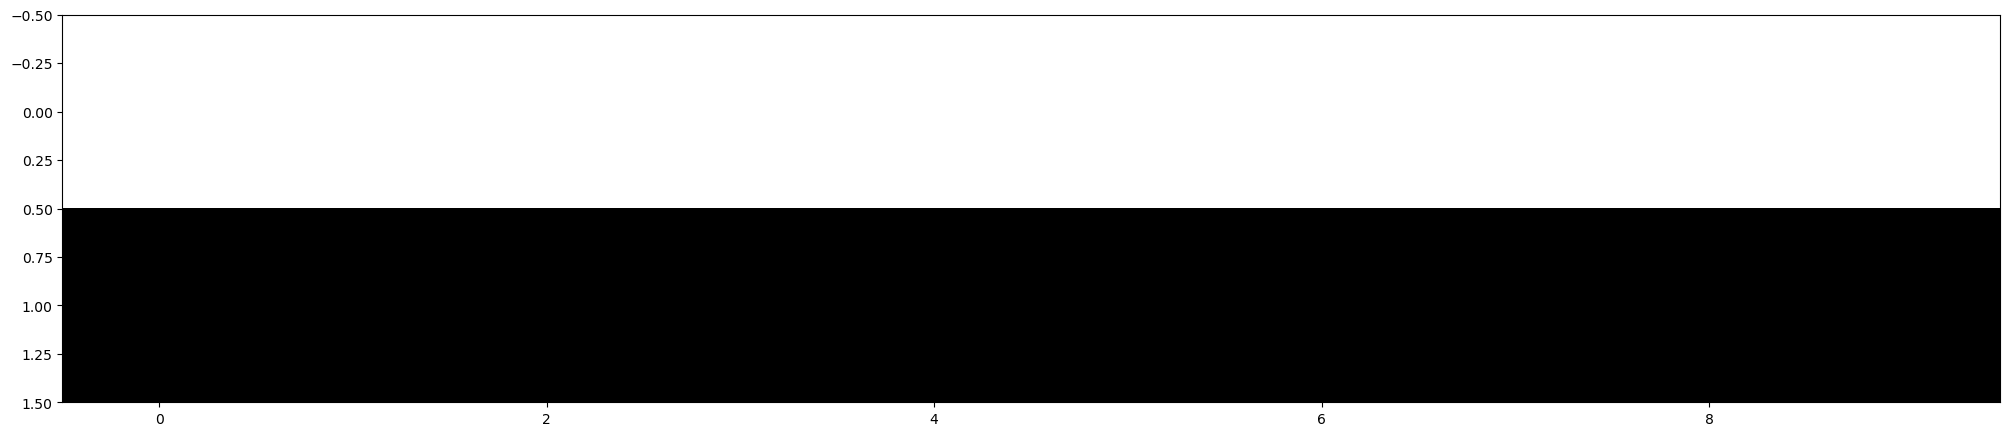

In [34]:
# global plt options
plt.rc('figure', figsize=(25, 25), dpi=100)

toy_gray = np.array([
    [1]*10,
    [0]*10
])
print(toy_gray.shape)
plt.imshow(toy_gray, cmap='gray')

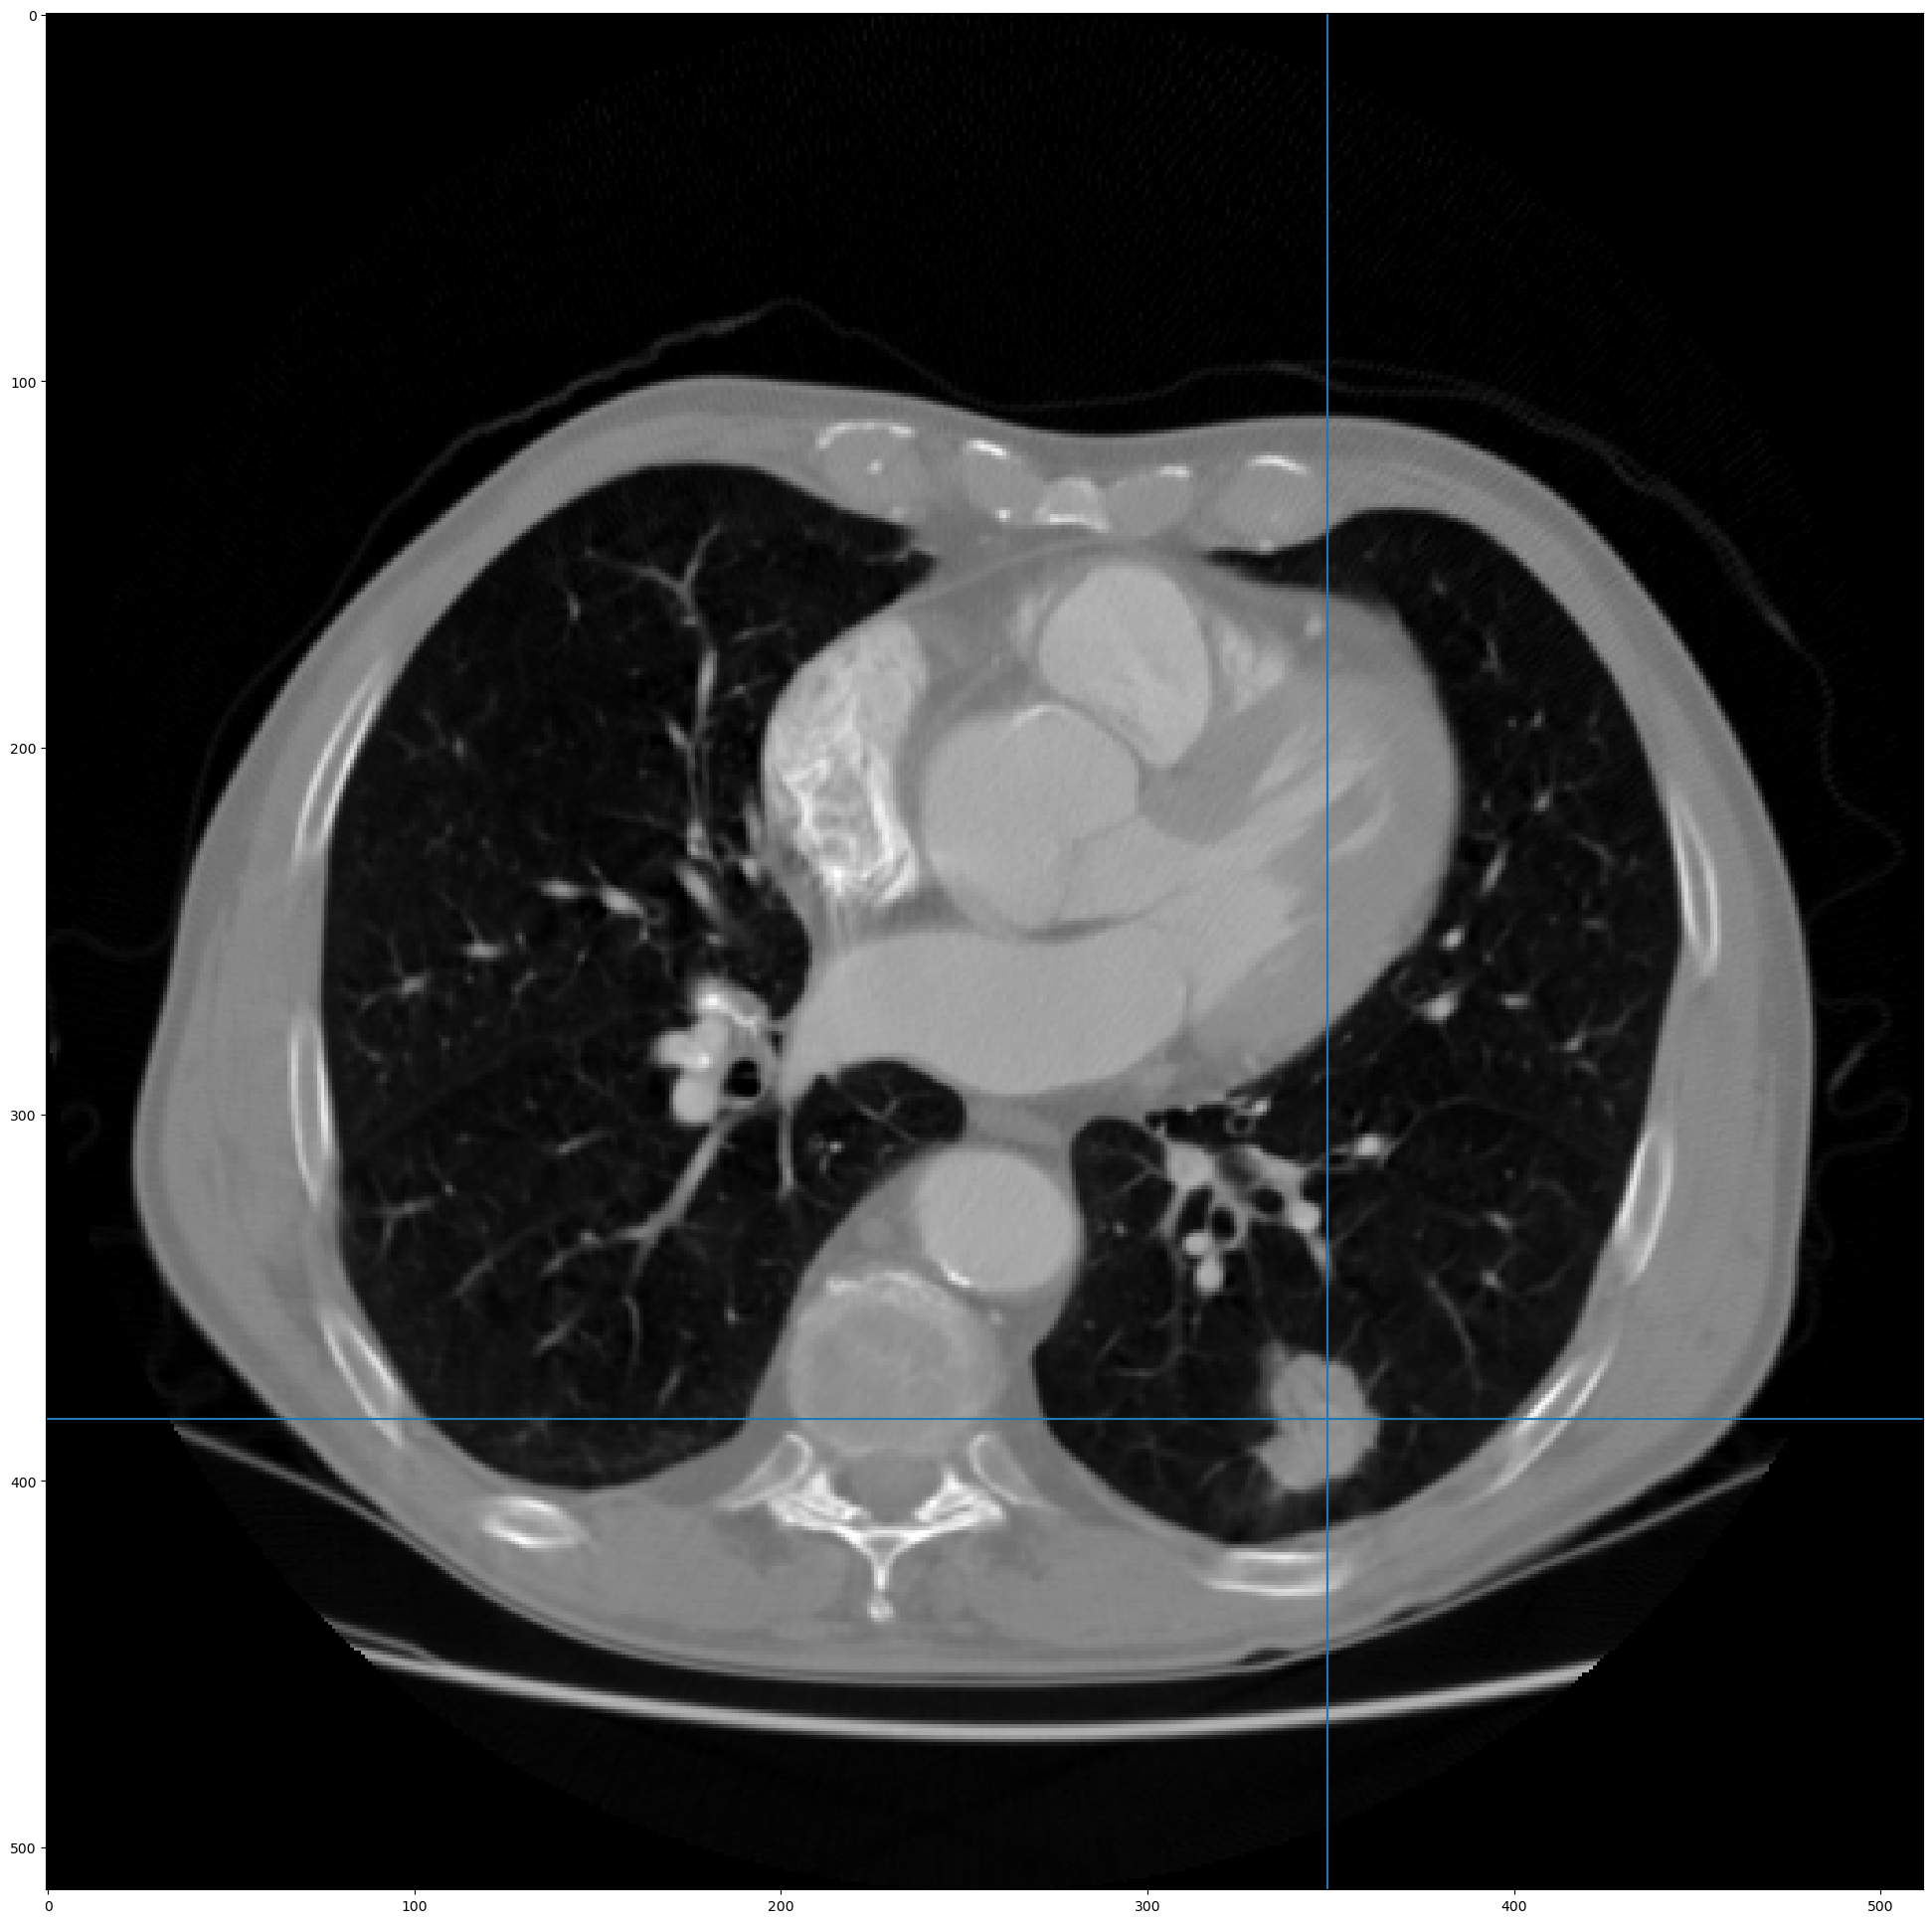

In [33]:
# visualization of the nodule with center labeled in blue line
plt.imshow(ct_np[68], cmap='gray')
plt.axvline(x=center_irc.col) # column is vertical
plt.axhline(y=center_irc.row)
plt.show()

In [39]:
# get segmented nodule
def buildAnnotationMask(center_irc, ct_np, threshold_hu=-700):
    ci = center_irc.index
    cc = center_irc.col
    cr = center_irc.row
    
    boundingbox = np.zeros_like(ct_np, dtype=np.bool)
    
    index_radius = 2
    try:
        while ct_np[ci + index_radius, cr, cc] > threshold_hu and \
                ct_np[ci - index_radius, cr, cc] > threshold_hu:
            index_radius += 1
    except IndexError:
        index_radius -= 1
    
    row_radius = 2
    try:
        while ct_np[ci, cr + row_radius, cc] > threshold_hu and \
                ct_np[ci, cr - row_radius, cc] > threshold_hu:
            row_radius += 1
    except IndexError:
        row_radius -= 1
        
    col_radius = 2
    try:
        while ct_np[ci, cr, cc + col_radius] > threshold_hu and \
                ct_np[ci, cr, cc + col_radius] > threshold_hu:
            col_radius += 1
    except IndexError:
        col_radius -= 1
    
    boundingbox[ci-index_radius: ci+index_radius+1,
               cr-row_radius: cr+row_radius+1,
               cc-col_radius: cc+col_radius+1] = True
    mask = boundingbox & (ct_np > threshold_hu)
    return mask

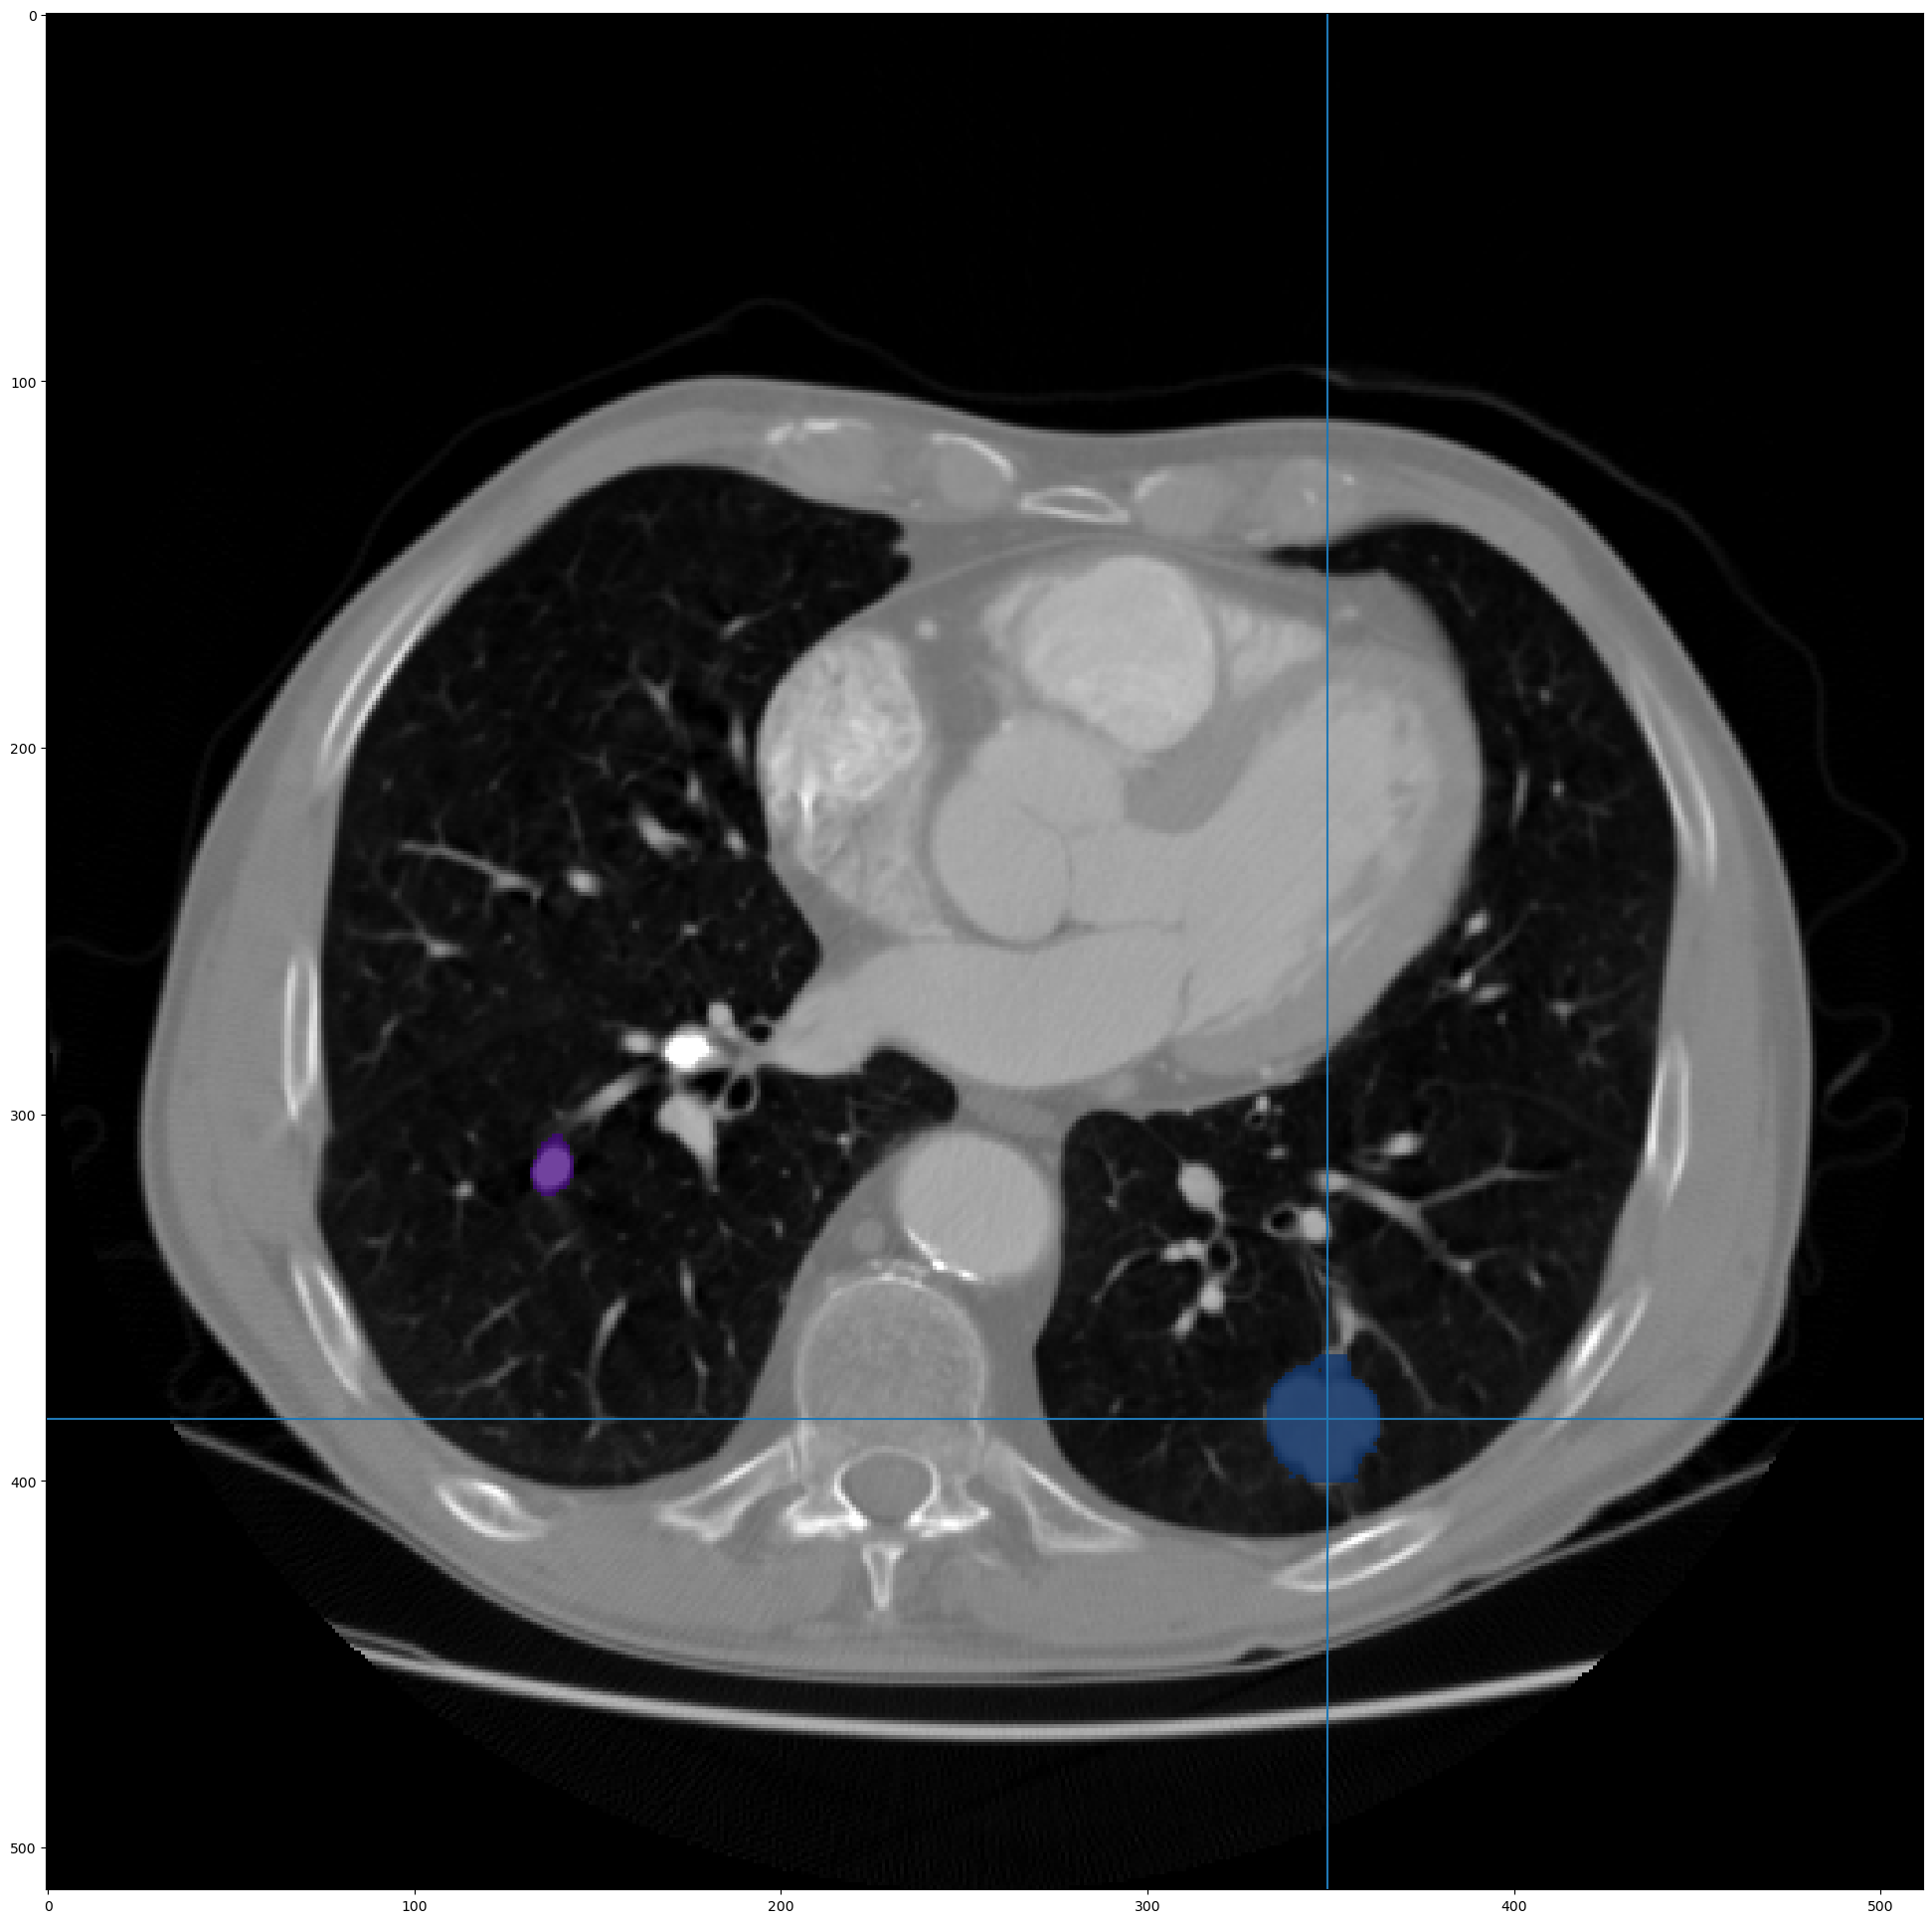

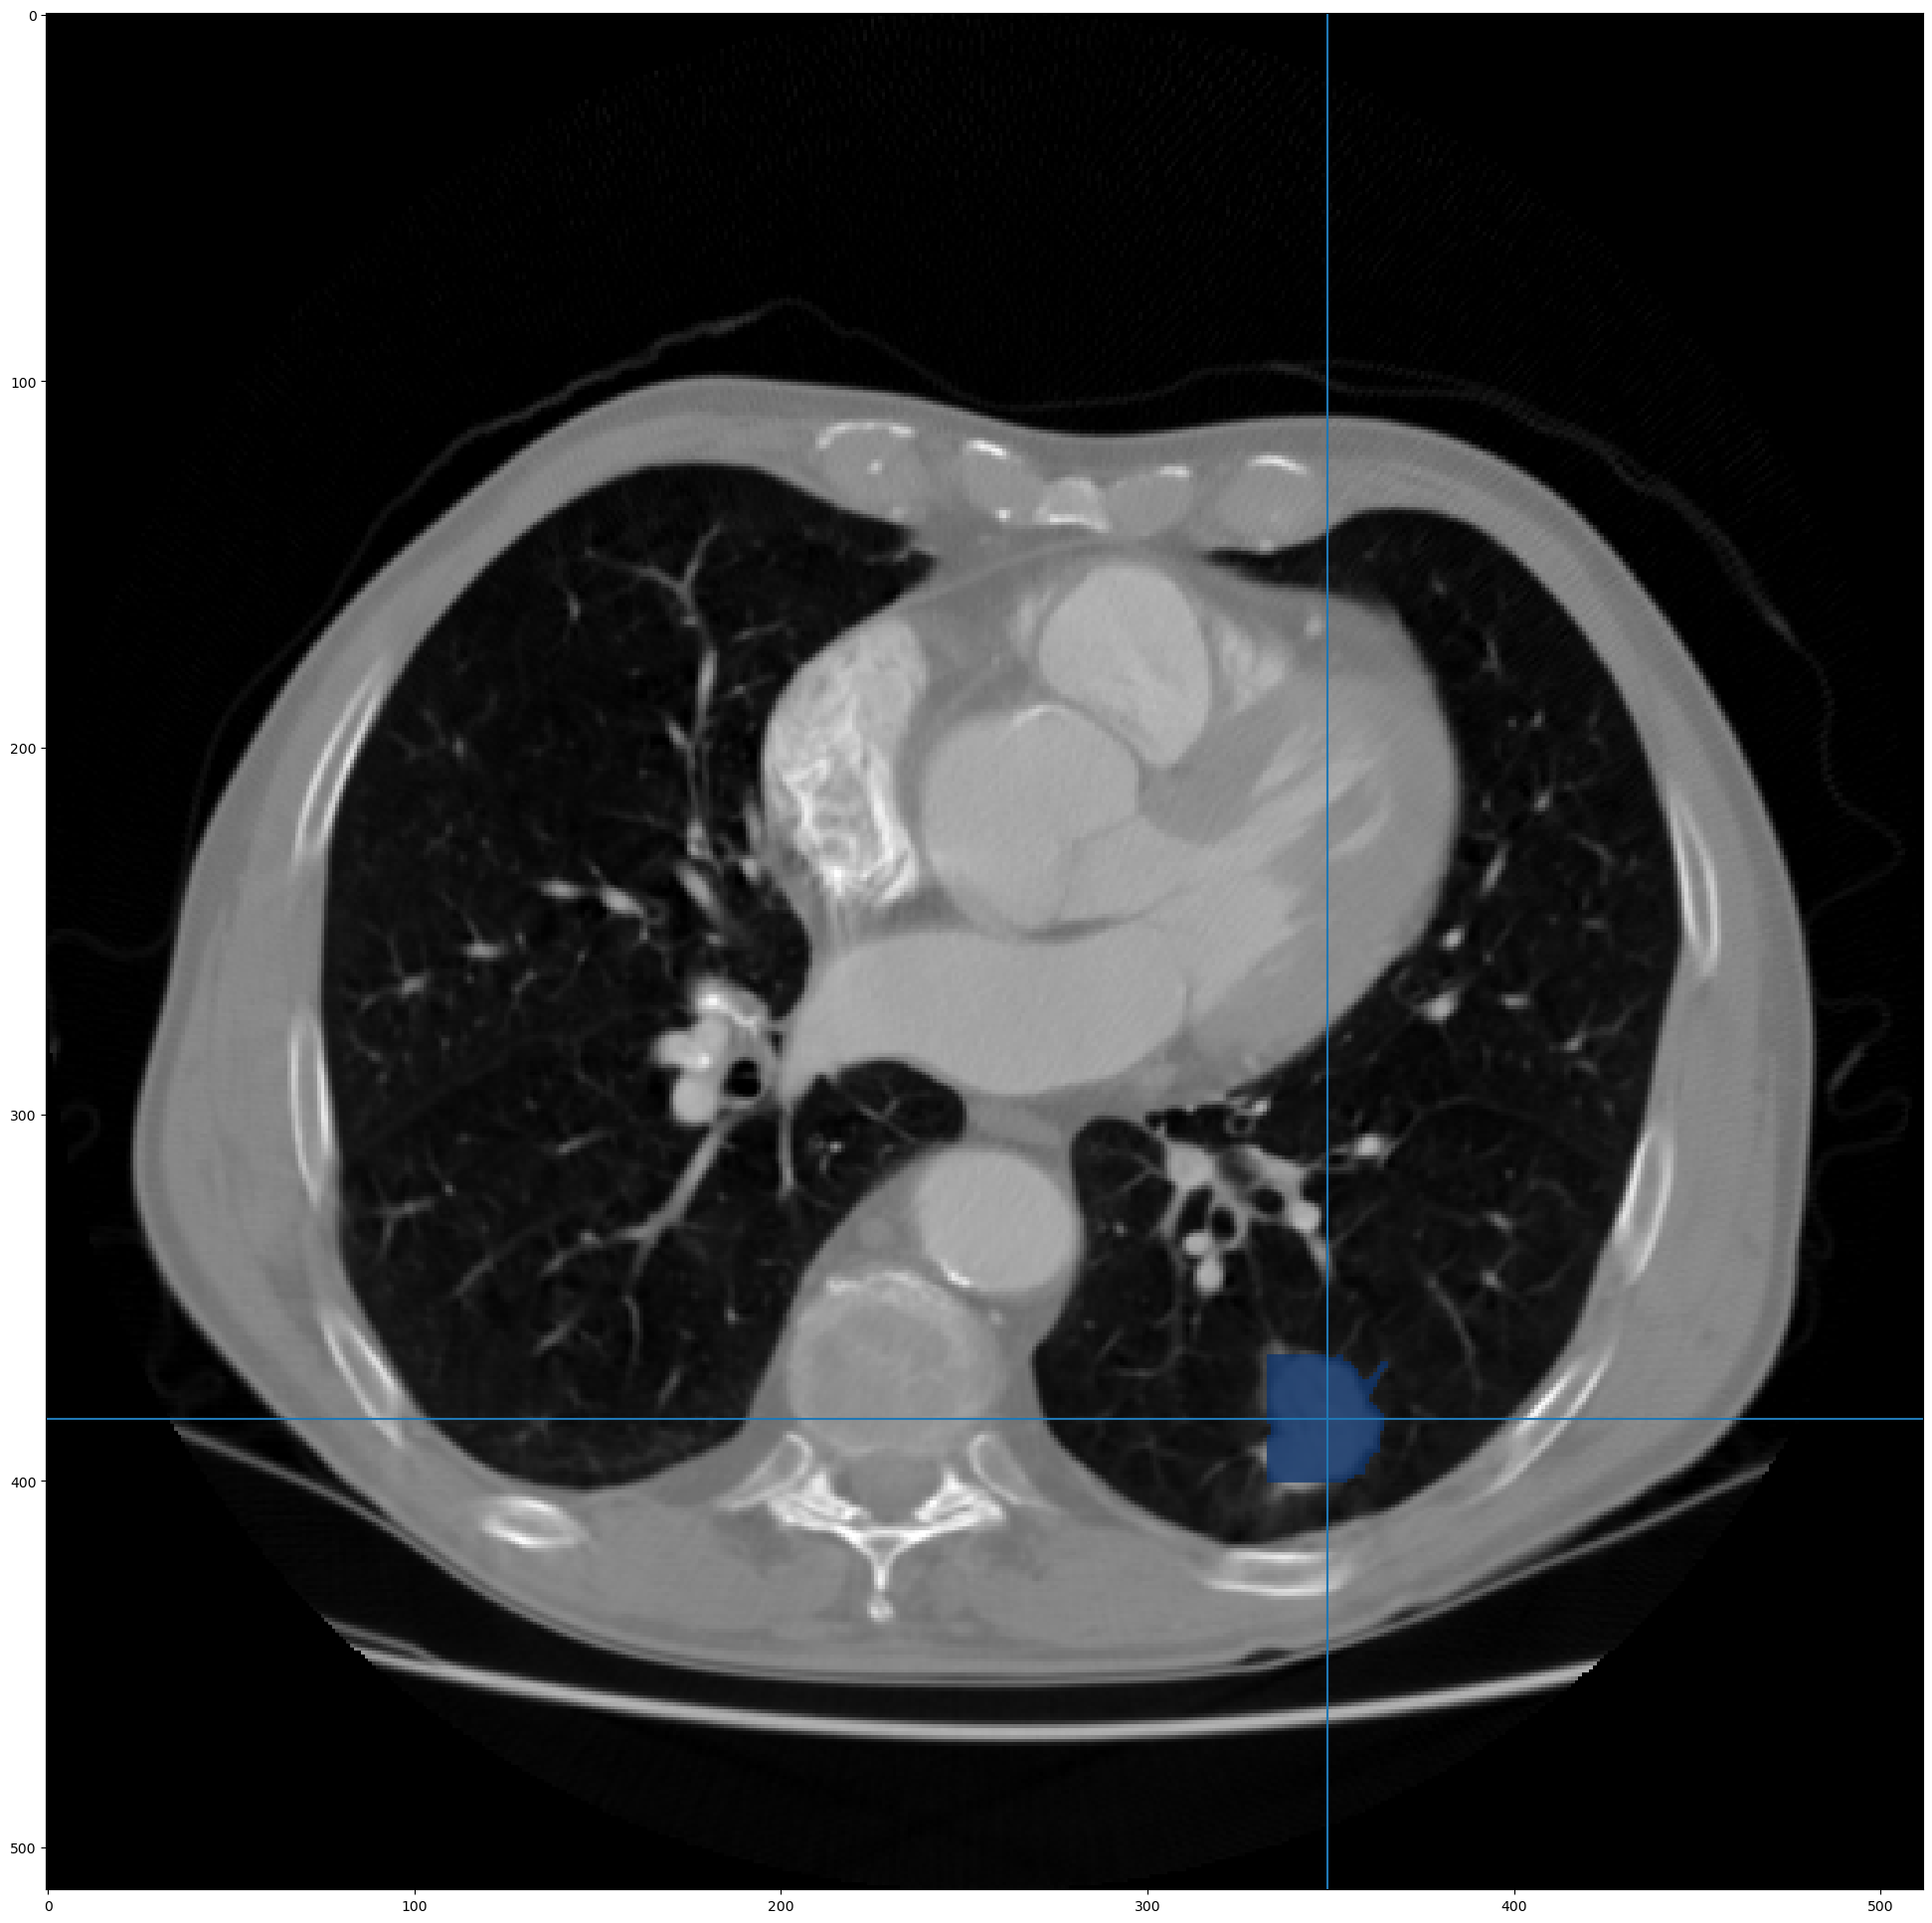

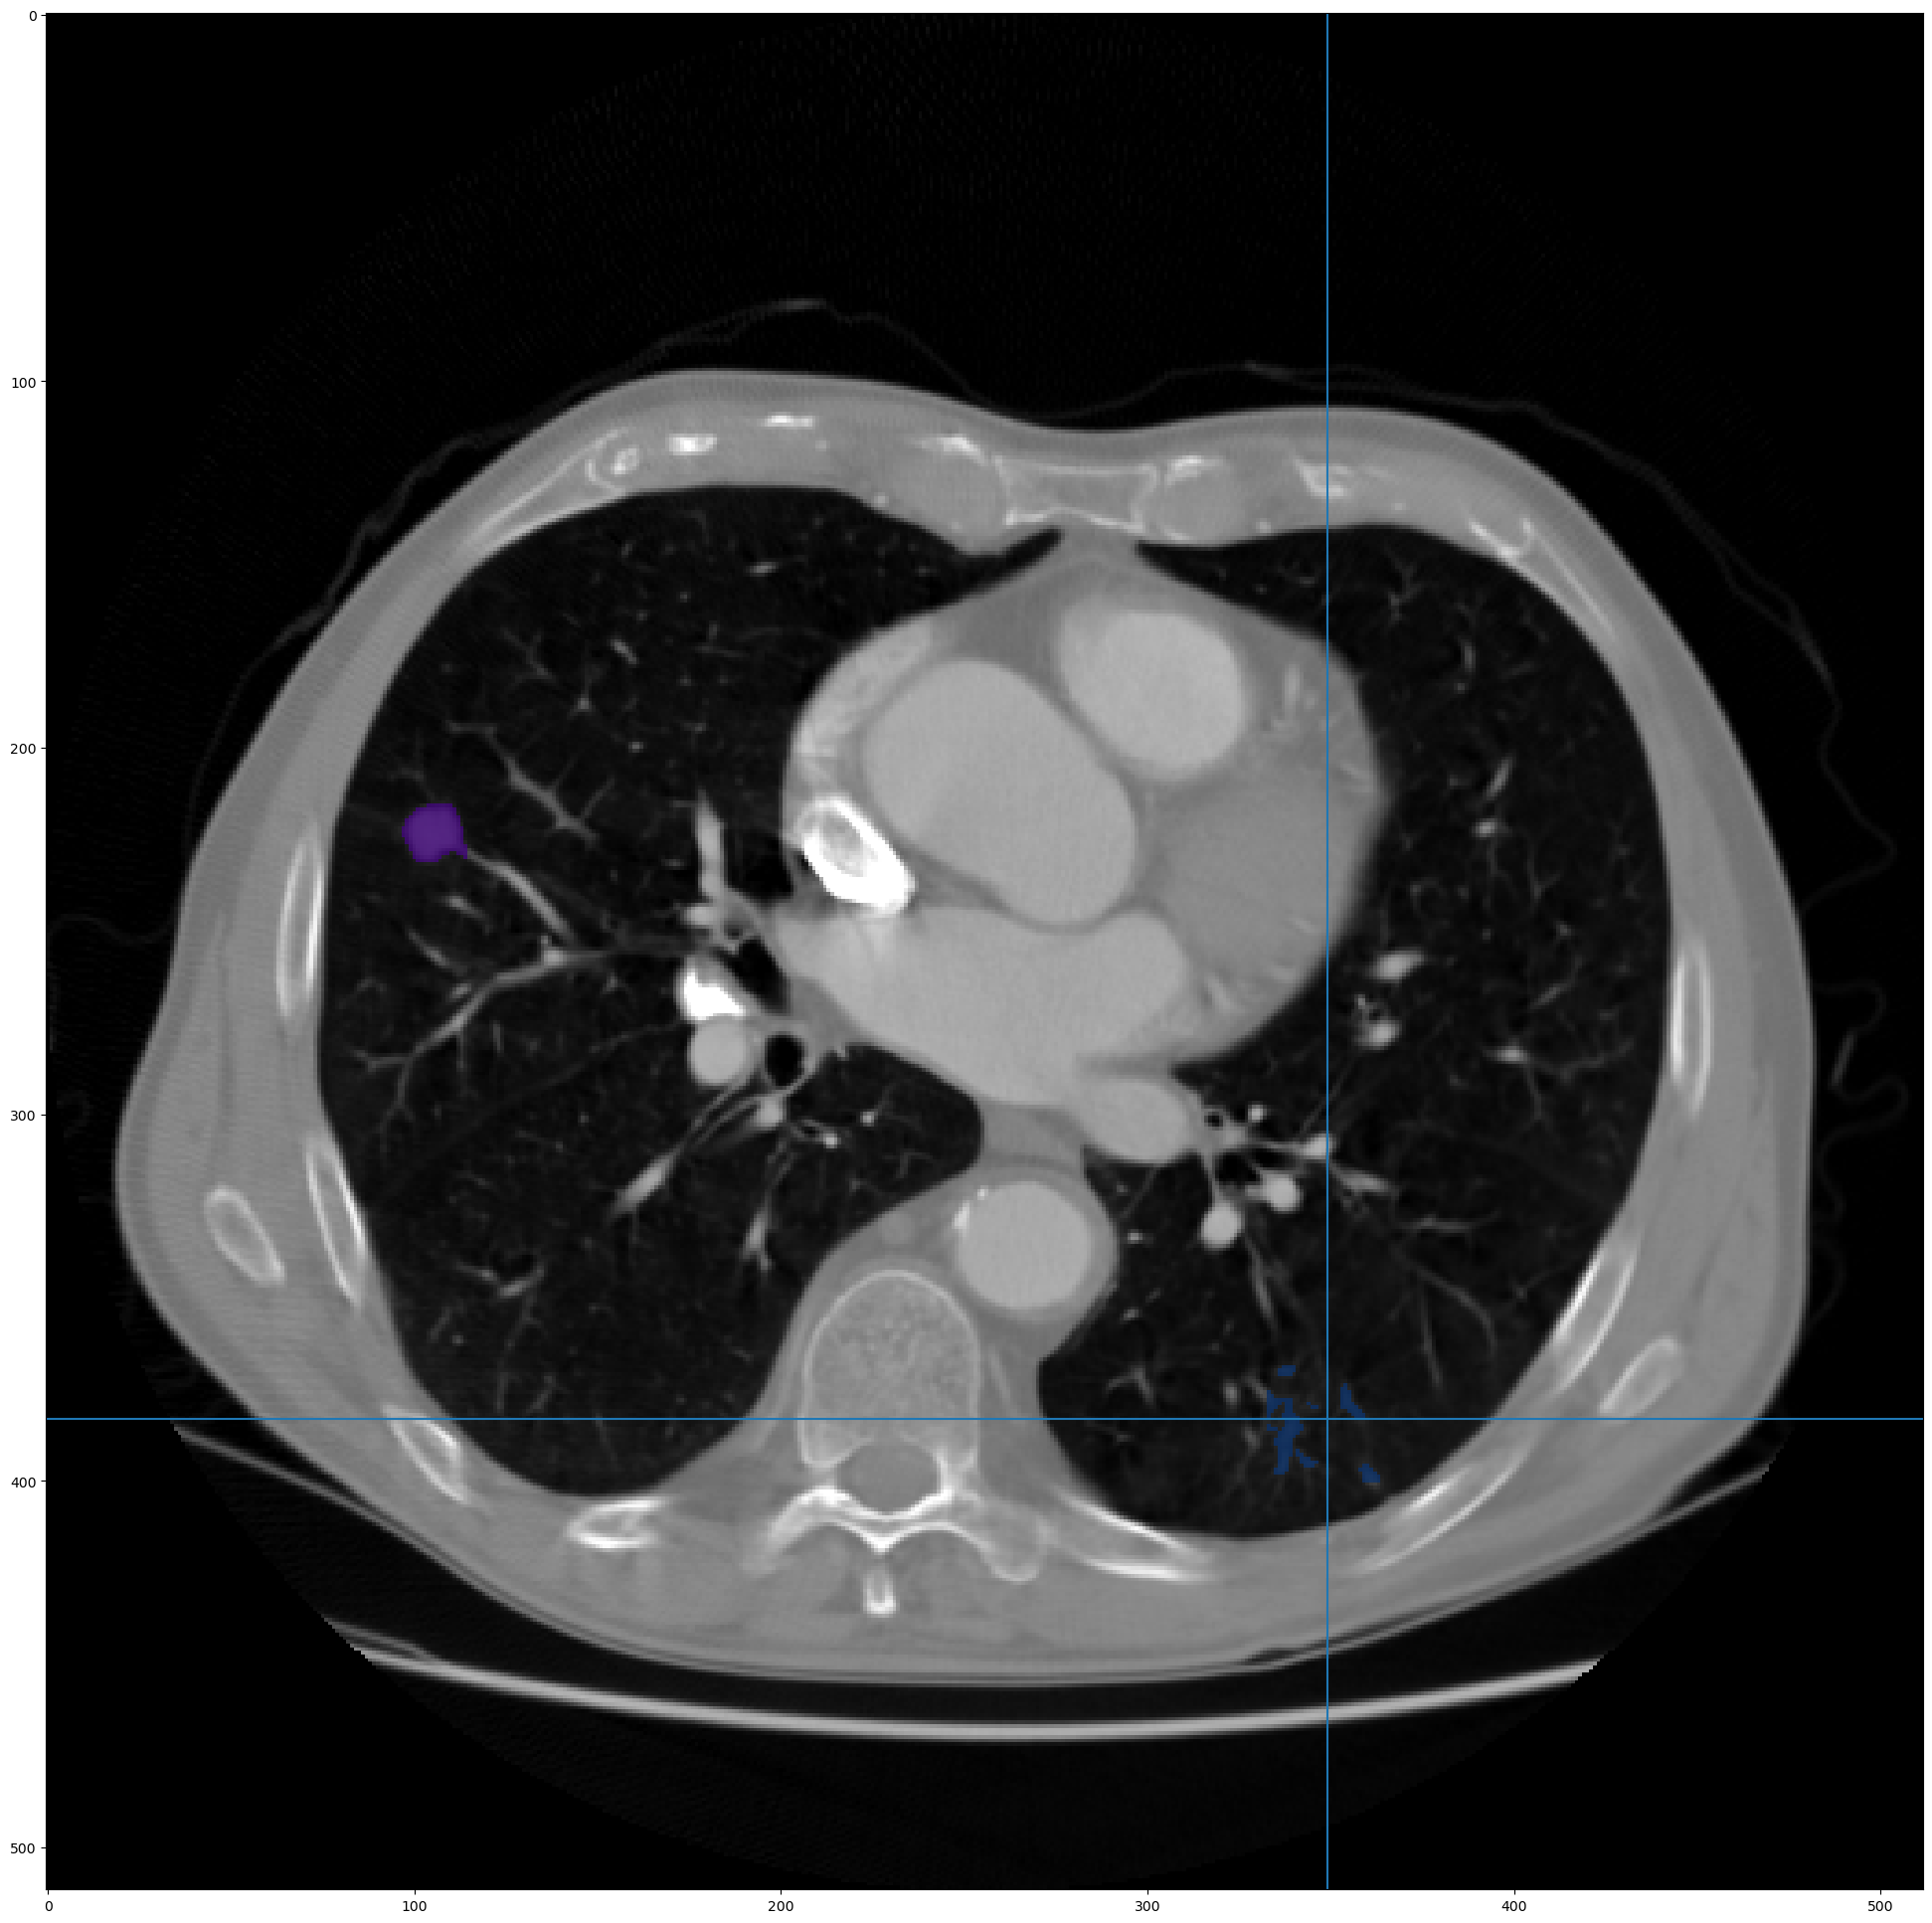

In [82]:
mask_nodule = buildAnnotationMask(center_irc, ct_np)
mask_no1 = buildAnnotationMask(center_irc_no1, ct_np)
mask_no2 = buildAnnotationMask(center_irc_no2, ct_np)


def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = copy.deepcopy(cmap)
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.75, N+4)
    return mycmap
tpurple = transparent_cmap(plt.cm.Purples)
tblue = transparent_cmap(plt.cm.Blues)

# mask visualization
i = 65
plt.imshow(ct_np[i], cmap='gray')
plt.axvline(x=center_irc.col) # column is vertical
plt.axhline(y=center_irc.row)
plt.imshow(mask_nodule[i], clim=(0, 1), cmap=tblue)
plt.imshow(mask_no1[i], clim=(0, 1), cmap=tpurple)
plt.imshow(mask_no2[i], clim=(0, 1), cmap=tpurple)
plt.show()

i = 68
plt.imshow(ct_np[i], cmap='gray')
plt.axvline(x=center_irc.col) # column is vertical
plt.axhline(y=center_irc.row)
plt.imshow(mask_nodule[i], clim=(0, 1), cmap=tblue)
plt.imshow(mask_no1[i], clim=(0, 1), cmap=tpurple)
plt.imshow(mask_no2[i], clim=(0, 1), cmap=tpurple)
plt.show()

i = 73
plt.imshow(ct_np[i], cmap='gray')
plt.axvline(x=center_irc.col) # column is vertical
plt.axhline(y=center_irc.row)
plt.imshow(mask_nodule[i], clim=(0, 1), cmap=tblue)
plt.imshow(mask_no1[i], clim=(0, 1), cmap=tpurple)
plt.imshow(mask_no2[i], clim=(0, 1), cmap=tpurple)
plt.show()